##### Copyright 2020 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rabi oscillation experiment

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/benchmarks/rabi_oscillations"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/benchmarks/rabi_oscillations.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/benchmarks/rabi_oscillations.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/benchmarks/rabi_oscillations.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [2]:
try:
    import cirq
    import recirq
except ImportError:
    !pip install -U pip
    !pip install --quiet cirq
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
    import cirq
    import recirq

import numpy as np
import cirq_google

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In this experiment, you are going to use Cirq to check that rotating a qubit by an increasing angle, and then measuring the qubit, produces Rabi oscillations. This requires you to do the following things:

1. Prepare the $|0\rangle$ state.
2. Rotate by an angle $\theta$ around the $X$ axis.
3. Measure to see if the result is a 1 or a 0.
4. Repeat steps 1-3 $k$ times.
5. Report the fraction of $\frac{\text{Number of 1's}}{k}$
found in step 3.

## 1. Getting to know Cirq

Cirq emphasizes the details of implementing quantum algorithms on near term devices.
For example, when you work on a qubit in Cirq you don't operate on an unspecified qubit that will later be mapped onto a device by a hidden step.
Instead, you are always operating on specific qubits at specific locations that you specify.

Suppose you are working with a 54 qubit Sycamore chip.
This device is included in Cirq by default.
It is called `cirq_google.Sycamore`, and you can see its layout by printing it.

In [3]:
working_device = cirq_google.Sycamore
print(working_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

For this experiment you only need one qubit and you can just pick whichever one you like.

In [4]:
my_qubit = cirq.GridQubit(5, 6)

Once you've chosen your qubit you can build circuits that use it.

findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


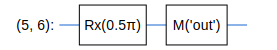

In [5]:
from cirq.contrib.svg import SVGCircuit

# Create a circuit with X, Ry(pi/2) and H.
my_circuit = cirq.Circuit(
    # Rotate the qubit pi/2 radians around the X axis.
    cirq.rx(np.pi / 2).on(my_qubit),
    # Measure the qubit.
    cirq.measure(my_qubit, key="out"),
)
SVGCircuit(my_circuit)

Now you can simulate sampling from your circuit using `cirq.Simulator`.

In [6]:
sim = cirq.Simulator()
samples = sim.sample(my_circuit, repetitions=10)

You can also get properties of the circuit, such as the density matrix of the circuit's output or the state vector just before the terminal measurement.

In [7]:
state_vector_before_measurement = sim.simulate(my_circuit[:-1])
sampled_state_vector_after_measurement = sim.simulate(my_circuit)

print(f"State before measurement:")
print(state_vector_before_measurement)
print(f"State after measurement:")
print(sampled_state_vector_after_measurement)

State before measurement:
measurements: (no measurements)

qubits: (cirq.GridQubit(5, 6),)
output vector: 0.707|0⟩ - 0.707j|1⟩

phase:
output vector: |⟩
State after measurement:
measurements: out=1

qubits: (cirq.GridQubit(5, 6),)
output vector: -1j|1⟩

phase:
output vector: |⟩


You can also examine the outputs from a noisy environment.
For example, an environment where 10% depolarization is applied to each qubit after each operation in the circuit:

In [8]:
noisy_sim = cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.1))
noisy_post_measurement_state = noisy_sim.simulate(my_circuit)
noisy_pre_measurement_state = noisy_sim.simulate(my_circuit[:-1])

print("Noisy state after measurement:" + str(noisy_post_measurement_state))
print("Noisy state before measurement:" + str(noisy_pre_measurement_state))

Noisy state after measurement:measurements: out=1

qubits: (cirq.GridQubit(5, 6),)
final density matrix:
[[0.06666666+0.j 0.        +0.j]
 [0.        +0.j 0.9333333 +0.j]]

phase:
final density matrix:
[[1.+0.j]]
Noisy state before measurement:measurements: (no measurements)

qubits: (cirq.GridQubit(5, 6),)
final density matrix:
[[0.49999994+0.j         0.        +0.43333334j]
 [0.        -0.43333334j 0.49999994+0.j        ]]

phase:
final density matrix:
[[1.+0.j]]


## 2. Parameterized Circuits and Sweeps

Now that you have some of the basics end to end, you can create a parameterized circuit that rotates by an angle $\theta$:

findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.


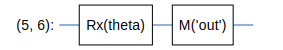

In [9]:
import sympy

theta = sympy.Symbol("theta")

parameterized_circuit = cirq.Circuit(
    cirq.rx(theta).on(my_qubit), cirq.measure(my_qubit, key="out")
)
SVGCircuit(parameterized_circuit)

In the above block you saw that there is a `sympy.Symbol` that you placed in the circuit. Cirq supports symbolic computation involving circuits. What this means is that when you construct `cirq.Circuit` objects you can put placeholders in many of the classical control parameters of the circuit which you can fill with values later on.

Now if you wanted to use `cirq.simulate` or `cirq.sample` with the parameterized circuit you would also need to specify a value for `theta`.

In [10]:
sim.sample(parameterized_circuit, params={theta: 2}, repetitions=10)

theta  out
0      2    1
1      2    1
2      2    1
3      2    1
4      2    1
5      2    0
6      2    1
7      2    0
8      2    0
9      2    0

You can also specify *multiple* values of `theta`, and get samples back for each value.

In [11]:
sim.sample(parameterized_circuit, params=[{theta: 0.5}, {theta: np.pi}], repetitions=10)

theta  out
0  0.500000    0
1  0.500000    0
2  0.500000    0
3  0.500000    0
4  0.500000    0
5  0.500000    0
6  0.500000    0
7  0.500000    0
8  0.500000    0
9  0.500000    0
0  3.141593    1
1  3.141593    1
2  3.141593    1
3  3.141593    1
4  3.141593    1
5  3.141593    1
6  3.141593    1
7  3.141593    1
8  3.141593    1
9  3.141593    1

Cirq has shorthand notation you can use to sweep `theta` over a range of values.

In [12]:
sim.sample(
    parameterized_circuit,
    params=cirq.Linspace(theta, start=0, stop=np.pi, length=5),
    repetitions=5,
)

theta  out
0  0.000000    0
1  0.000000    0
2  0.000000    0
3  0.000000    0
4  0.000000    0
0  0.785398    0
1  0.785398    0
2  0.785398    0
3  0.785398    0
4  0.785398    0
0  1.570796    1
1  1.570796    1
2  1.570796    0
3  1.570796    1
4  1.570796    1
0  2.356194    0
1  2.356194    0
2  2.356194    1
3  2.356194    1
4  2.356194    1
0  3.141593    1
1  3.141593    1
2  3.141593    1
3  3.141593    1
4  3.141593    1

The result value being returned by `sim.sample` is a `pandas.DataFrame` object.
Pandas is a common library for working with table data in python.
You can use standard pandas methods to analyze and summarize your results.

<AxesSubplot: xlabel='theta'>

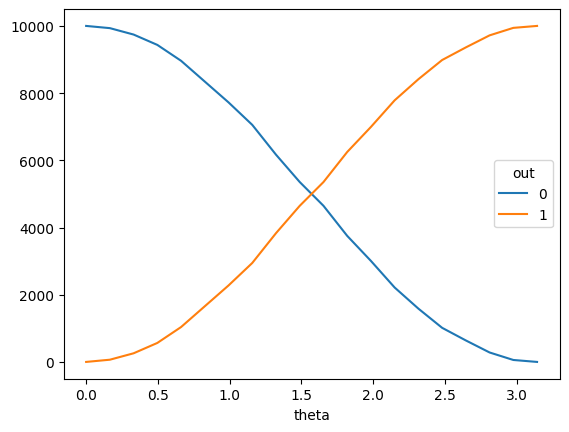

In [13]:
import pandas

big_results = sim.sample(
    parameterized_circuit,
    params=cirq.Linspace(theta, start=0, stop=np.pi, length=20),
    repetitions=10_000,
)

# big_results is too big to look at. Plot cross tabulated data instead.
pandas.crosstab(big_results.theta, big_results.out).plot()

## 3. The ReCirq experiment

[ReCirq](https://github.com/quantumlib/ReCirq) comes with a pre-written Rabi oscillation experiment `recirq.benchmarks.rabi_oscillations`, which performs the steps outlined at the start of this tutorial to create a circuit that exhibits Rabi Oscillations or [Rabi Cycles](https://en.wikipedia.org/wiki/Rabi_cycle). 

This method takes a `cirq.Sampler`, which could be a simulator or a network connection to real hardware, as well as a qubit to test and two iteration parameters, `num_points` and `repetitions`. It then runs `repetitions` many experiments on the provided `sampler`, where each experiment is a circuit that rotates the chosen `qubit` by some $\theta$ Rabi angle around the $X$ axis (by applying an exponentiated $X$ gate). The result is a sequence of the expected probabilities of the chosen qubit at each of the Rabi angles. 

<AxesSubplot: xlabel='Rabi Angle (Radian)', ylabel='Excited State Probability'>

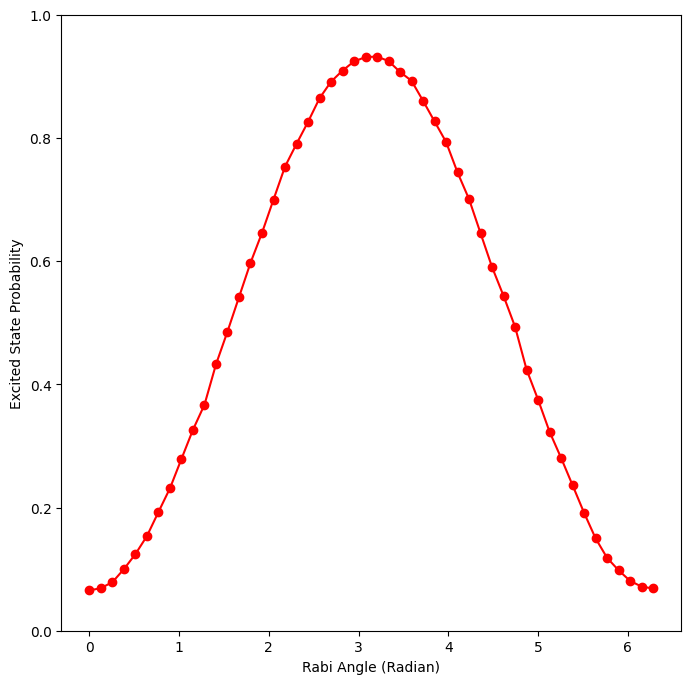

In [14]:
import datetime
from recirq.benchmarks import rabi_oscillations

result = rabi_oscillations(
    sampler=noisy_sim, qubit=my_qubit, num_points=50, repetitions=10000
)
result.plot()

Notice that you can tell from the plot that you used the noisy simulator you defined earlier.
You can also tell that the amount of depolarization is roughly 10%.

## 4. Exercise: Find the best qubit

As you have seen, you can use Cirq to perform a Rabi oscillation experiment.
You can either make the experiment yourself out of the basic pieces made available by Cirq, or use the prebuilt experiment method.

Now you're going to put this knowledge to the test.

There is some amount of depolarizing noise on each qubit.
Your goal is to characterize every qubit from the Sycamore chip using a Rabi oscillation experiment, and find the qubit with the lowest noise according to the secret noise model.

In [15]:
import hashlib


class SecretNoiseModel(cirq.NoiseModel):
    def noisy_operation(self, op):
        # Hey! No peeking!
        q = op.qubits[0]
        v = hashlib.sha256(str(q).encode()).digest()[0] / 256
        yield cirq.depolarize(v).on(q)
        yield op


secret_noise_sampler = cirq.DensityMatrixSimulator(noise=SecretNoiseModel())

qubit cirq.GridQubit(7, 6)


<AxesSubplot: xlabel='Rabi Angle (Radian)', ylabel='Excited State Probability'>

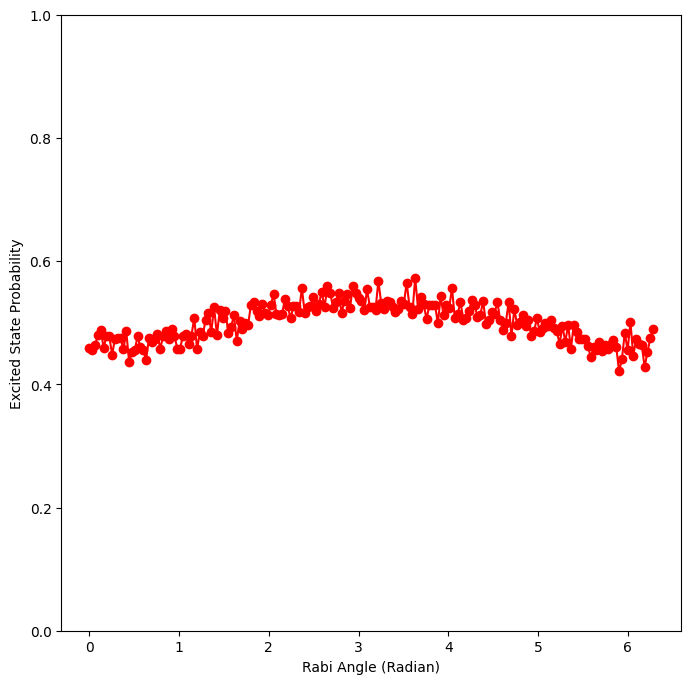

In [16]:
q = list(cirq_google.Sycamore.metadata.qubit_set)[3]
print("qubit", repr(q))
rabi_oscillations(sampler=secret_noise_sampler, qubit=q).plot()